# Notebook with demostration of different methods for augmentation of skeletons that we get from videos with people doing exercises

In [1]:
from __future__ import annotations
import os
from pathlib import Path
from typing import Iterable, Tuple

import numpy as np
import cv2

try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x

def ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)

### Skeleton augmentations

Assumed skeleton array shape: (T, J, 2) — per-frame 2D joints in pixels.
We implement:
- Rotate around image center
- Scale from center
- Translate (pixels)
- Jitter (Gaussian noise)
- Horizontal flip (W-known)
- Temporal resample/crop

If original image width `W` isn’t known, either provide it or normalize skeletons to [-1, 1] first, then flip via x -> -x.


In [26]:
from dataclasses import dataclass

@dataclass
class ImageInfo:
    width: int
    height: int


def skel_rotate(skel: np.ndarray, angle_deg: float, img: ImageInfo) -> np.ndarray:
    cx, cy = img.width / 2.0, img.height / 2.0
    theta = np.deg2rad(angle_deg)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
    centered = skel - np.array([[cx, cy]], dtype=np.float32)
    rot = centered @ R.T
    return rot + np.array([[cx, cy]], dtype=np.float32)


def skel_scale(skel: np.ndarray, scale: float, img: ImageInfo) -> np.ndarray:
    cx, cy = img.width / 2.0, img.height / 2.0
    centered = skel - np.array([[cx, cy]], dtype=np.float32)
    scaled = centered * scale
    return scaled + np.array([[cx, cy]], dtype=np.float32)


def skel_translate(skel: np.ndarray, dx: float, dy: float) -> np.ndarray:
    return skel + np.array([[dx, dy]], dtype=np.float32)


def skel_jitter(skel: np.ndarray, sigma: float=2.0) -> np.ndarray:
    noise = np.random.normal(0, sigma, size=skel.shape).astype(np.float32)
    return skel + noise


def skel_flip_horizontal(skel: np.ndarray, img: ImageInfo) -> np.ndarray:
    out = skel.copy()
    out[..., 0] = (img.width - 1) - out[..., 0]
    return out


def skel_time_crop(skel: np.ndarray, ratio: float=0.8) -> np.ndarray:
    T = skel.shape[0]
    new_T = max(1, int(T * ratio))
    if new_T >= T:
        return skel
    start = np.random.randint(0, T - new_T + 1)
    return skel[start:start+new_T]


def skel_time_resample(skel: np.ndarray, new_T: int) -> np.ndarray:
    T = skel.shape[0]
    if new_T <= 0:
        return skel
    idx = np.linspace(0, T-1, new_T).round().astype(int)
    idx = np.clip(idx, 0, T-1)
    return skel[idx]


def demo_skeleton_augs():
    T, J = 10, 5
    img = ImageInfo(width=640, height=360)
    base = np.stack([
        np.stack([
            np.array([100 + t*2 + j*5, 50 + j*10], dtype=np.float32)
            for j in range(J)
        ], axis=0)
        for t in range(T)
    ], axis=0)

    rot = np.stack([skel_rotate(base[t], 10.0, img) for t in range(T)], axis=0)
    scl = np.stack([skel_scale(base[t], 1.1, img) for t in range(T)], axis=0)
    trn = np.stack([skel_translate(base[t], 5.0, -3.0) for t in range(T)], axis=0)
    jit = np.stack([skel_jitter(base[t], 1.5) for t in range(T)], axis=0)
    flp = np.stack([skel_flip_horizontal(base[t], img) for t in range(T)], axis=0)
    crp = skel_time_crop(base, 0.7)
    rsm = skel_time_resample(base, 6)

    return {
        "base": base,
        "rot": rot,
        "scale": scl,
        "translate": trn,
        "jitter": jit,
        "flip": flp,
        "time_crop": crp,
        "time_resample": rsm,
    }


### Batch skeleton augmentation from .npy files

This section loads skeleton arrays saved as `.npy` (shape (T, J, 2) or (T, J, 3) with confidence), applies selected augmentations using known frame width/height, and saves augmented copies while preserving dtype and confidence channel if present.

Edit the paths and the `IMG_W`, `IMG_H` values below to match your data.


#### How the batch skeleton augmentation (.npy) cell works

1) Configuration: set `SKELETON_DIR` (where input `.npy` files live), `OUT_DIR` (where to save), and frame size `IMG_W`, `IMG_H`. The output directory is created if missing.
2) Define `AUGS`: a dict mapping a filename suffix to a function that takes coordinates of shape (T, J, 2) and returns augmented coordinates. Included: rotate, scale, translate, jitter, horizontal flip, temporal crop, temporal resample.
3) Scan `SKELETON_DIR` for `.npy` files.
4) For each file:
   - Load `arr` and validate shape (T, J, 2|3). Keep the original `dtype`.
   - Detect confidence channel (`has_conf` when C=3). Split into `coords = arr[..., :2]` and `conf = arr[..., 2:]` if present.
   - For each augmentation compute `aug_xy` (x,y only). If `conf` exists and the time length T changed (crop/resample), align `conf` via `skel_time_resample`, then concatenate back to get (T, J, 3). Otherwise, concatenate the original `conf`.
   - Cast back to the original `dtype` and save to `OUT_DIR` with a suffix (e.g., `_rot10`, `_tcrop`).

Result: for each input `.npy` one output per augmentation is produced; the original `dtype` is preserved; if confidence exists, the third channel is preserved as well.


In [27]:
from typing import List

BASE_DIR = Path.cwd().parent

SKELETON_DIR = Path(BASE_DIR / "data/skeletons")
OUT_DIR = Path(BASE_DIR / "data/augmented_skeletons")
IMG_W, IMG_H = 640, 360
ensure_dir(OUT_DIR)

AUGS = {
    "rot10": lambda arr: np.stack([skel_rotate(arr[t, :, :2], 10.0, ImageInfo(IMG_W, IMG_H)) for t in range(arr.shape[0])], axis=0),
    "scale110": lambda arr: np.stack([skel_scale(arr[t, :, :2], 1.1, ImageInfo(IMG_W, IMG_H)) for t in range(arr.shape[0])], axis=0),
    "trans_5_-3": lambda arr: np.stack([skel_translate(arr[t, :, :2], 5.0, -3.0) for t in range(arr.shape[0])], axis=0),
    "jitter": lambda arr: np.stack([skel_jitter(arr[t, :, :2], 1.5) for t in range(arr.shape[0])], axis=0),
    "flip": lambda arr: np.stack([skel_flip_horizontal(arr[t, :, :2], ImageInfo(IMG_W, IMG_H)) for t in range(arr.shape[0])], axis=0),
    "tcrop": lambda arr: skel_time_crop(arr[:, :, :2], 0.8),
    "tresamp6": lambda arr: skel_time_resample(arr[:, :, :2], 6),
}

sk_files: List[Path] = []
if SKELETON_DIR.exists():
    sk_files = sorted([p for p in SKELETON_DIR.glob("*.npy")])
else:
    print("Skeleton dir does not exist:", SKELETON_DIR)

for npy_path in tqdm(sk_files):
    arr = np.load(npy_path)
    if arr.ndim != 3 or arr.shape[-1] not in (2, 3):
        print("Skip incompatible shape:", npy_path, arr.shape)
        continue
    dtype = arr.dtype
    has_conf = (arr.shape[-1] == 3)
    coords = arr[..., :2].astype(np.float32)
    conf = arr[..., 2:] if has_conf else None

    for suf, fn in AUGS.items():
        aug_xy = fn(coords)
        if has_conf:
            if aug_xy.shape[0] != arr.shape[0]:
                new_T = aug_xy.shape[0]
                conf_new = skel_time_resample(conf, new_T) if new_T != conf.shape[0] else conf
                aug = np.concatenate([aug_xy, conf_new], axis=-1)
            else:
                aug = np.concatenate([aug_xy, conf], axis=-1)
        else:
            aug = aug_xy
        aug = aug.astype(dtype, copy=False)
        out_path = OUT_DIR / f"{npy_path.stem}_{suf}.npy"
        ensure_dir(out_path.parent)
        np.save(out_path, aug)
print("Saved augmented skeletons to:", OUT_DIR)


100%|██████████| 3/3 [00:00<00:00, 122.80it/s]

Saved augmented skeletons to: /Users/victor/Documents/vs_files/Action_Recognition/data/augmented_skeletons


#### Test with 3 files

In [36]:
# Targeted test on three skeleton files (pick first three from data/skeletons)
BASE_DIR = Path.cwd().parent

TEST_FILES = [
    Path(BASE_DIR / "data/skeletons/0b3c6ea5f943fbc80b9c6d20373cc3bf.npy"),
    Path(BASE_DIR / "data/skeletons/0b4dd5fa651633b90bb7e4a455caaf4c.npy"),
    Path(BASE_DIR / "data/skeletons/0b9d78bb7ad1f347ed0a6af7262da572.npy"),
]

IMG_W, IMG_H = 640, 360
OUT_DIR = Path(BASE_DIR / "data/augmented_skeletons_test")
ensure_dir(OUT_DIR)

for npy_path in TEST_FILES:
    arr = np.load(npy_path)
    if arr.ndim != 3 or arr.shape[-1] not in (2, 3):
        print("Skip incompatible shape:", npy_path, arr.shape)
        continue
    dtype = arr.dtype
    has_conf = (arr.shape[-1] == 3)
    coords = arr[..., :2].astype(np.float32)
    conf = arr[..., 2:] if has_conf else None

    for suf, fn in AUGS.items():
        aug_xy = fn(coords)
        if has_conf:
            if aug_xy.shape[0] != arr.shape[0]:
                new_T = aug_xy.shape[0]
                conf_new = skel_time_resample(conf, new_T) if new_T != conf.shape[0] else conf
                aug = np.concatenate([aug_xy, conf_new], axis=-1)
            else:
                aug = np.concatenate([aug_xy, conf], axis=-1)
        else:
            aug = aug_xy
        aug = aug.astype(dtype, copy=False)
        out_path = OUT_DIR / f"{npy_path.stem}_{suf}.npy"
        np.save(out_path, aug)
    print("Augmented:", npy_path.name, "->", OUT_DIR)


Augmented: 0b3c6ea5f943fbc80b9c6d20373cc3bf.npy -> /Users/victor/Documents/vs_files/Action_Recognition/data/augmented_skeletons_test
Augmented: 0b4dd5fa651633b90bb7e4a455caaf4c.npy -> /Users/victor/Documents/vs_files/Action_Recognition/data/augmented_skeletons_test
Augmented: 0b9d78bb7ad1f347ed0a6af7262da572.npy -> /Users/victor/Documents/vs_files/Action_Recognition/data/augmented_skeletons_test


#### Check type

In [37]:
BASE_DIR = Path.cwd().parent

orig = Path(BASE_DIR / "data/skeletons/0b3c6ea5f943fbc80b9c6d20373cc3bf.npy")

IMG_W, IMG_H = 640, 360
out_dir = Path(BASE_DIR / "data/augmented_skeletons_test")
aug_paths = sorted(out_dir.glob(f"{orig.stem}_*.npy"))

arr0 = np.load(orig)
T0, J0, C0 = arr0.shape
print("orig:", arr0.shape, arr0.dtype)

for p in aug_paths:
    arr = np.load(p)
    print(p.name, "->", arr.shape, arr.dtype)
    if "_tcrop" in p.stem:
        assert arr.shape[0] < T0
    elif "_tresamp6" in p.stem:
        assert arr.shape[0] == 6
    else:
        assert arr.shape[0] == T0
    if C0 == 3:
        assert arr.shape[2] == 3
    else:
        assert arr.shape[2] == 2

orig: (49, 17, 3) float32
0b3c6ea5f943fbc80b9c6d20373cc3bf_flip.npy -> (49, 17, 3) float32
0b3c6ea5f943fbc80b9c6d20373cc3bf_jitter.npy -> (49, 17, 3) float32
0b3c6ea5f943fbc80b9c6d20373cc3bf_rot10.npy -> (49, 17, 3) float32
0b3c6ea5f943fbc80b9c6d20373cc3bf_scale110.npy -> (49, 17, 3) float32
0b3c6ea5f943fbc80b9c6d20373cc3bf_tcrop.npy -> (39, 17, 3) float32
0b3c6ea5f943fbc80b9c6d20373cc3bf_trans_5_-3.npy -> (49, 17, 3) float32
0b3c6ea5f943fbc80b9c6d20373cc3bf_tresamp6.npy -> (6, 17, 3) float32


In [38]:
BASE_DIR = Path.cwd().parent

data = np.load(BASE_DIR / "data/skeletons/0b3c6ea5f943fbc80b9c6d20373cc3bf.npy")

print(data.shape)

print("First frame (orig):")
print(data[0]) 
print(data[0, 0])

data1 = np.load(BASE_DIR / "data/augmented_skeletons_test/0b3c6ea5f943fbc80b9c6d20373cc3bf_flip.npy")

print(data1.shape)

print("\nFirst frame (augmented):")
print(data1[0]) 
print(data1[0, 0])

(49, 17, 3)
First frame (orig):
[[1.71322098e+02 1.21599564e+02 9.88917470e-01]
 [1.76614304e+02 1.18680008e+02 9.85222280e-01]
 [1.68325943e+02 1.18370483e+02 9.20247972e-01]
 [1.87045685e+02 1.22255722e+02 9.36038315e-01]
 [1.66081482e+02 1.21657700e+02 3.41832161e-01]
 [1.98538727e+02 1.39886856e+02 9.89978433e-01]
 [1.57727875e+02 1.38593582e+02 9.80428636e-01]
 [2.17625824e+02 1.06342621e+02 9.63149011e-01]
 [1.43540894e+02 1.04614494e+02 9.57552075e-01]
 [2.20913544e+02 7.39672165e+01 9.40750062e-01]
 [1.44039810e+02 7.45982971e+01 9.43886578e-01]
 [1.85741470e+02 2.15389664e+02 8.91559243e-01]
 [1.56021591e+02 2.14411423e+02 8.84795666e-01]
 [1.92367172e+02 2.40000000e+02 1.20780841e-01]
 [1.47710693e+02 2.40000000e+02 1.21171385e-01]
 [1.92333771e+02 2.22976364e+02 7.96720199e-03]
 [1.55217239e+02 2.26019165e+02 8.34085606e-03]]
[171.3221     121.59956      0.98891747]
(49, 17, 3)

First frame (augmented):
[[4.67677917e+02 1.21599564e+02 9.88917470e-01]
 [4.62385681e+02 1.18680

### Visualization utilities (COCO-like skeleton)

This section defines COCO-style edges and plotting helpers to visualize skeletons and compare original vs augmented coordinates.


In [7]:
# COCO-like edges for 17 joints (matching many YOLO/COCO keypoint orders)
COCO_EDGES = [
    (0, 1), (1, 3),  # nose -> eyes/ears (approx)
    (0, 2), (2, 4),
    (5, 6), (5, 7), (7, 9),  # left shoulder->elbow->wrist
    (6, 8), (8, 10),         # right shoulder->elbow->wrist
    (5, 11), (6, 12),        # shoulders to hips
    (11, 12),                # hip connection
    (11, 13), (13, 15),      # left hip->knee->ankle
    (12, 14), (14, 16),      # right hip->knee->ankle
]

import matplotlib.pyplot as plt


def plot_skeleton(ax, xy: np.ndarray, img_w: int, img_h: int, color: str = "tab:blue", alpha: float = 0.9, linewidth: float = 2.0):
    ax.set_xlim(0, img_w - 1)
    ax.set_ylim(img_h - 1, 0)
    ax.set_aspect('equal')
    ax.scatter(xy[:, 0], xy[:, 1], c=color, s=12, alpha=alpha)
    for i, j in COCO_EDGES:
        if i < xy.shape[0] and j < xy.shape[0]:
            x1, y1 = xy[i]
            x2, y2 = xy[j]
            ax.plot([x1, x2], [y1, y2], color=color, alpha=alpha, linewidth=linewidth)


def show_compare_frame(orig_xy: np.ndarray, aug_xy: np.ndarray, img_w: int, img_h: int, title: str = "Comparison (orig vs aug)"):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    axes[0].set_title("Original")
    plot_skeleton(axes[0], orig_xy, img_w, img_h, color="tab:blue")
    axes[1].set_title("Augmented")
    plot_skeleton(axes[1], aug_xy, img_w, img_h, color="tab:orange")
    fig.suptitle(title)
    plt.show()


### Compare original vs augmented skeletons

Pick a sample `.npy` from `data/skeletons`, load one augmented variant from `data/augmented_skeletons_test`, and visualize a chosen frame side-by-side using COCO-like edges.


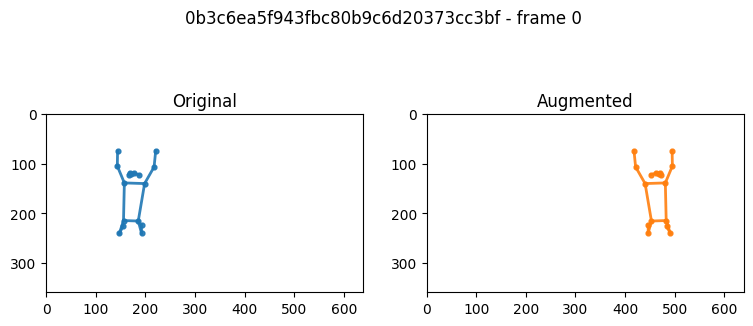

In [8]:
# Demo: visualize first frame of original vs augmented (flip) for first file
BASE_DIR = Path.cwd().parent
sk_dir = Path(BASE_DIR / "data/skeletons")
aug_dir = Path(BASE_DIR / "data/augmented_skeletons_test")

orig_path = sorted(sk_dir.glob("*.npy"))[0]
aug_path = next(aug_dir.glob(f"{orig_path.stem}_flip.npy"))

orig = np.load(orig_path)   # (T, J, 2|3)
aug = np.load(aug_path)

# choose frame index
frame_idx = 0

# extract xy (ignore confidence if present)
orig_xy = orig[frame_idx, :, :2].astype(np.float32)
aug_xy = aug[frame_idx, :, :2].astype(np.float32)

IMG_W, IMG_H = 640, 360
show_compare_frame(orig_xy, aug_xy, IMG_W, IMG_H, title=f"{orig_path.stem} - frame {frame_idx}")


### Visualize all augmentations (grid)

Show original and all augmented variants side-by-side for quick visual comparison on the same frame index.


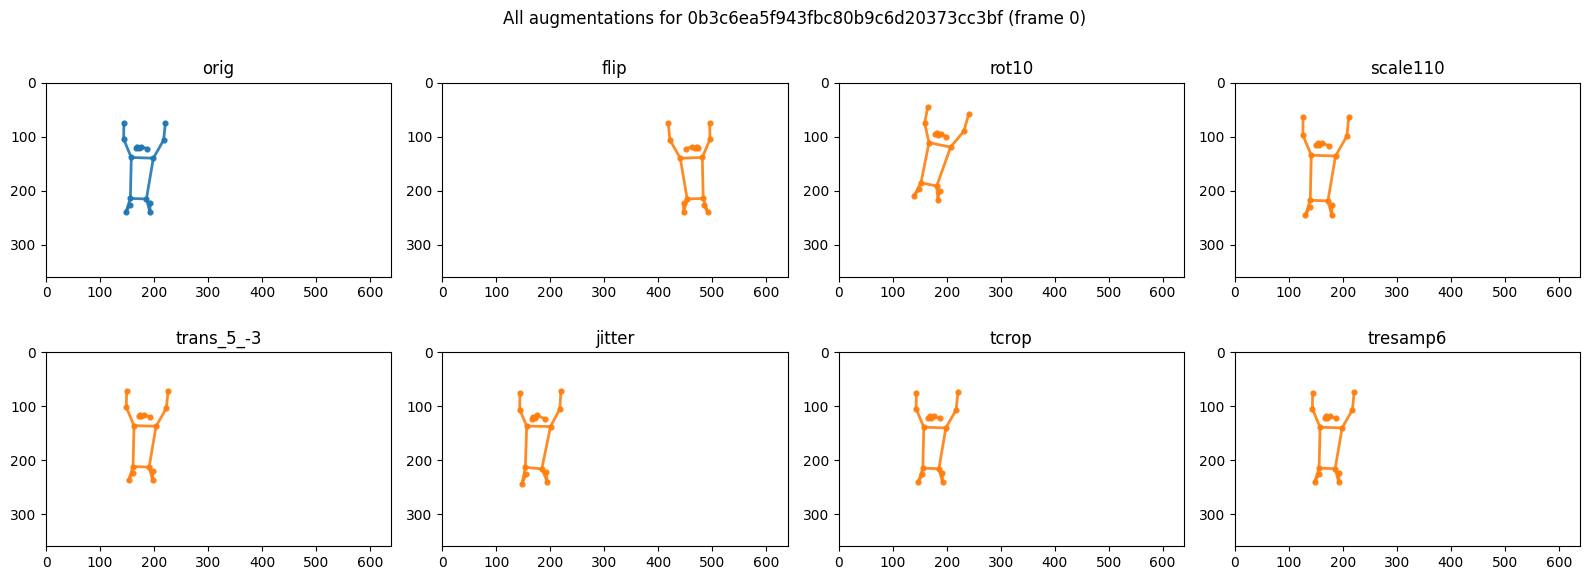

In [ ]:
# Grid viz: original + all augmentations for one file
BASE_DIR = Path.cwd().parent
sk_dir = Path(BASE_DIR / "data/skeletons")
aug_dir = Path(BASE_DIR / "data/augmented_skeletons_test")
IMG_W, IMG_H = 640, 360

orig_path = sorted(sk_dir.glob("*.npy"))[0]
orig = np.load(orig_path)

variants = [("orig", orig)]
for suf in ["flip", "rot10", "scale110", "trans_5_-3", "jitter", "tcrop", "tresamp6"]:
    cand = list(aug_dir.glob(f"{orig_path.stem}_{suf}.npy"))
    if cand:
        variants.append((suf, np.load(cand[0])))
    else:
        print("Missing:", suf)

# choose frame index
frame_idx = 0

cols = 4
rows = int(np.ceil(len(variants) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = np.array(axes).reshape(rows, cols)

for idx, (name, arr) in enumerate(variants):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    xy = arr[min(frame_idx, arr.shape[0] - 1), :, :2].astype(np.float32)
    plot_skeleton(ax, xy, IMG_W, IMG_H, color=("tab:blue" if name == "orig" else "tab:orange"))
    ax.set_title(name)

# hide any empty axes
for k in range(len(variants), rows * cols):
    r, c = divmod(k, cols)
    axes[r, c].axis("off")

fig.suptitle(f"All augmentations for {orig_path.stem} (frame {frame_idx})")
plt.tight_layout()
plt.show()



### Visualize all augmentations (grid) for 3 files

Render a 2x4 grid (orig + 7 augs) for each of the three selected skeleton files.


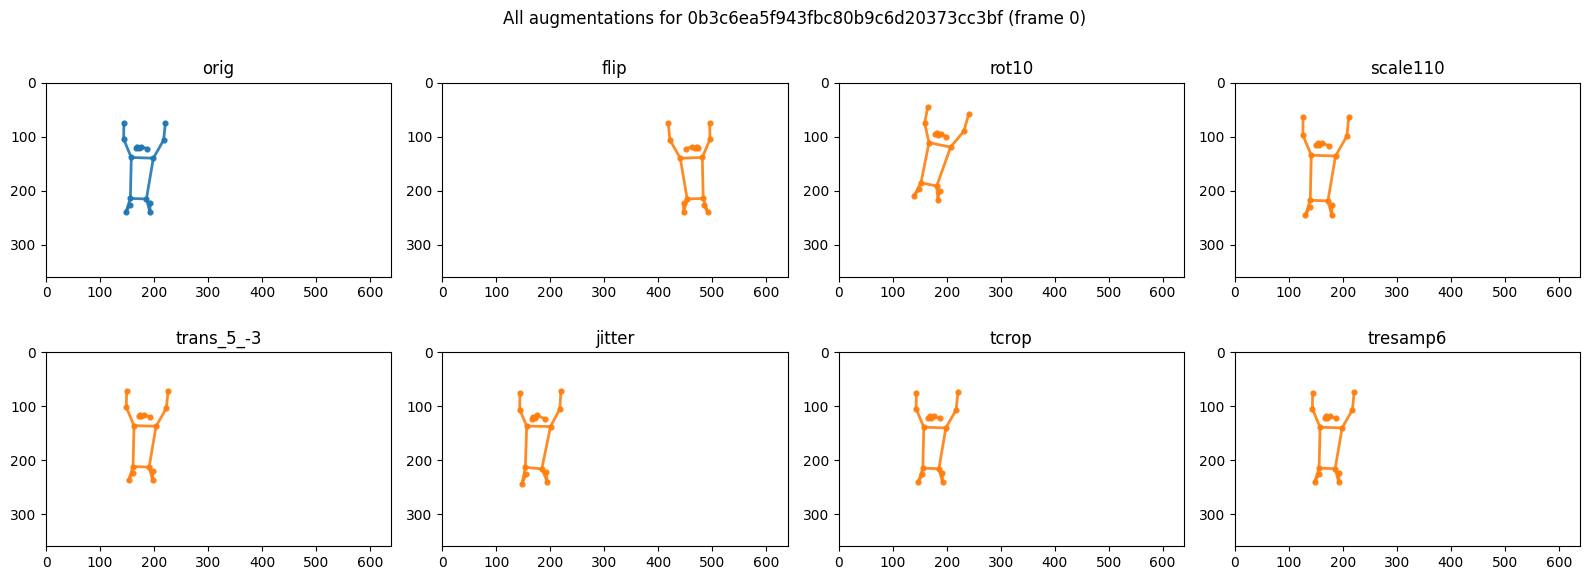

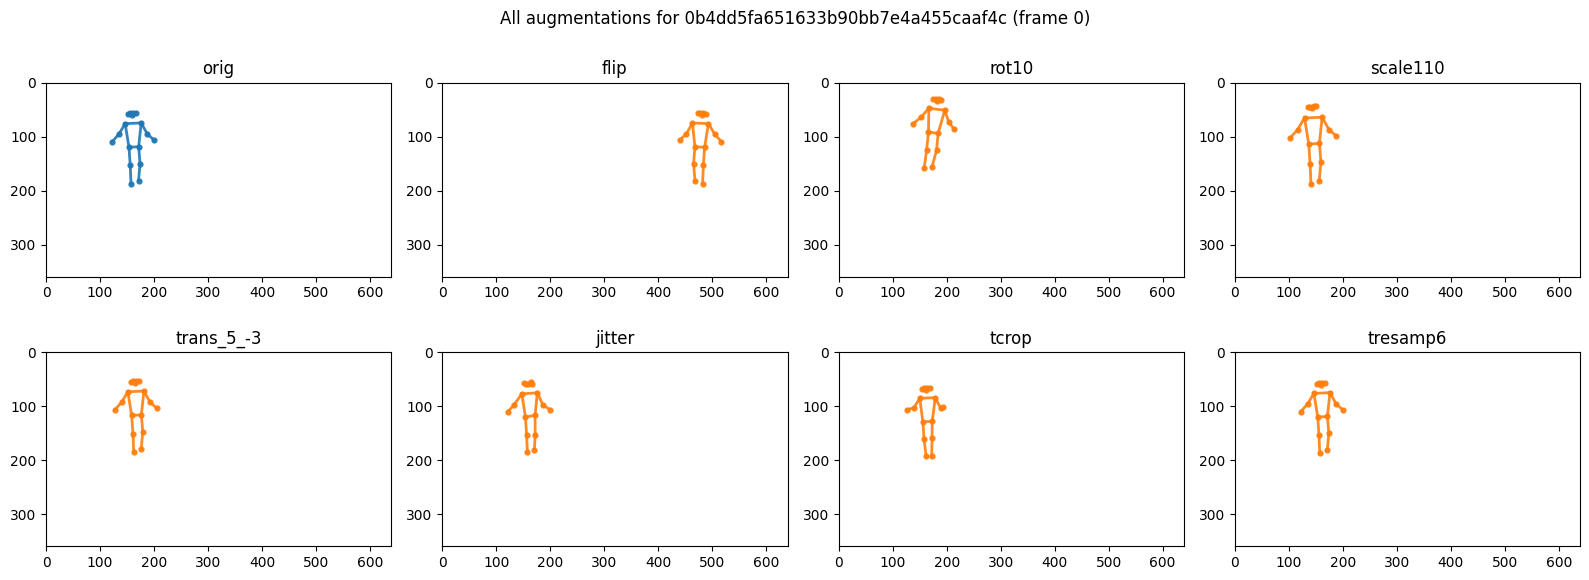

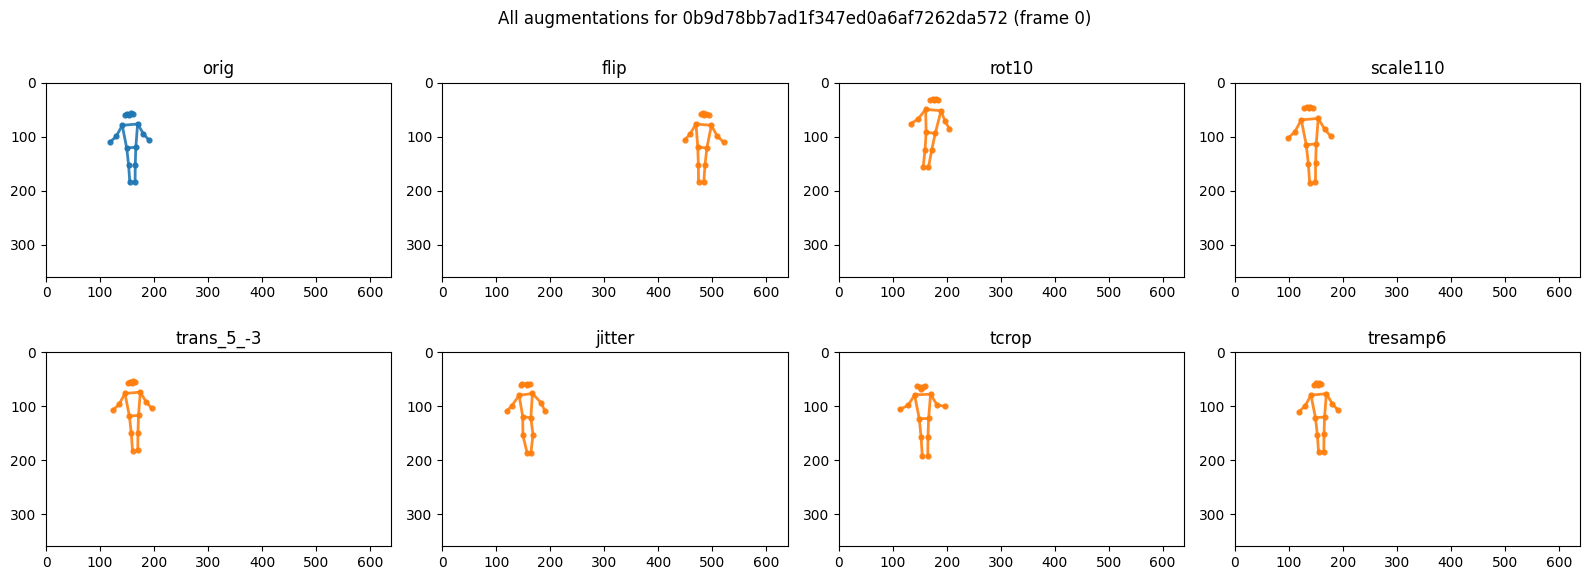

In [9]:
# Grid viz for three files: original + 7 augmentations each
BASE_DIR = Path.cwd().parent
sk_dir = Path(BASE_DIR / "data/skeletons")
aug_dir = Path(BASE_DIR / "data/augmented_skeletons_test")
IMG_W, IMG_H = 640, 360

# Pick three files (same three as in the test cell)
three_files = [
    Path(sk_dir / "0b3c6ea5f943fbc80b9c6d20373cc3bf.npy"),
    Path(sk_dir / "0b4dd5fa651633b90bb7e4a455caaf4c.npy"),
    Path(sk_dir / "0b9d78bb7ad1f347ed0a6af7262da572.npy"),
]

suffixes = ["flip", "rot10", "scale110", "trans_5_-3", "jitter", "tcrop", "tresamp6"]
frame_idx = 0

for npy_path in three_files:
    if not npy_path.exists():
        print("Skip missing:", npy_path)
        continue
    orig = np.load(npy_path)
    variants = [("orig", orig)]
    for suf in suffixes:
        cand = list(aug_dir.glob(f"{npy_path.stem}_{suf}.npy"))
        if cand:
            variants.append((suf, np.load(cand[0])))
        else:
            print("Missing:", npy_path.stem, suf)

    cols = 4
    rows = int(np.ceil(len(variants) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = np.array(axes).reshape(rows, cols)

    for idx, (name, arr) in enumerate(variants):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        # guard if temporal size differs
        t = min(frame_idx, arr.shape[0] - 1)
        xy = arr[t, :, :2].astype(np.float32)
        plot_skeleton(ax, xy, IMG_W, IMG_H, color=("tab:blue" if name == "orig" else "tab:orange"))
        ax.set_title(name)

    # hide any empty axes
    for k in range(len(variants), rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    fig.suptitle(f"All augmentations for {npy_path.stem} (frame {frame_idx})")
    plt.tight_layout()
    plt.show()


### Expected differences per augmentation

- Rotate (rot10): joint-to-joint distances stay the same; distances to image center rotate (angles change), bounding box rotates; centroid rotates around center.
- Scale (scale110): all distances (bones, centroid-to-center) scale by ~1.1; shape preserved; centroid moves away/toward center.
- Translate (trans_5_-3): bones unchanged; all x/y shift by ~(+5,-3); centroid shifts by same delta.
- Jitter (jitter): bones almost unchanged (very small noise); points slightly perturbed randomly.
- Flip (flip): horizontal mirror: x' ≈ (W-1) - x, y' ≈ y; bones preserved; left/right swap visually.
- Temporal crop (tcrop): fewer frames (T' < T), contiguous subsequence; per-frame coords identical to that segment.
- Temporal resample (tresamp6): exactly 6 frames; frames sampled along the original timeline (nearest-index sampling).


In [10]:
# Quantitative comparison: original vs all augmented variants for one file
BASE_DIR = Path.cwd().parent
sk_dir = Path(BASE_DIR / "data/skeletons")
aug_dir = Path(BASE_DIR / "data/augmented_skeletons_test")
IMG_W, IMG_H = 640, 360

orig_path = sorted(sk_dir.glob("*.npy"))[0]
orig = np.load(orig_path)
T0, J0, C0 = orig.shape

suffixes = ["flip", "rot10", "scale110", "trans_5_-3", "jitter", "tcrop", "tresamp6"]

# helper metrics

def centroid(xy: np.ndarray) -> np.ndarray:
    return xy.mean(axis=0)


def bone_lengths(xy: np.ndarray) -> np.ndarray:
    # simple all-pairs distance as a proxy; or pick COCO_EDGES only
    dists = []
    for (i, j) in COCO_EDGES:
        if i < xy.shape[0] and j < xy.shape[0]:
            d = np.linalg.norm(xy[i] - xy[j])
            dists.append(d)
    return np.array(dists, dtype=np.float32)


frame_idx = 0
orig_xy = orig[frame_idx, :, :2].astype(np.float32)
orig_cent = centroid(orig_xy)
orig_bones = bone_lengths(orig_xy)

for suf in suffixes:
    cand = list(aug_dir.glob(f"{orig_path.stem}_{suf}.npy"))
    if not cand:
        print(f"Missing augmented: {suf}")
        continue
    aug = np.load(cand[0])

    # time checks
    if suf == "tcrop":
        assert aug.shape[0] < T0, "tcrop: expected fewer frames"
    elif suf == "tresamp6":
        assert aug.shape[0] == 6, "tresamp6: expected 6 frames"
    else:
        assert aug.shape[0] == T0, f"{suf}: expected same T"

    aug_xy = aug[min(frame_idx, aug.shape[0]-1), :, :2].astype(np.float32)

    # metrics
    cent = centroid(aug_xy)
    bones = bone_lengths(aug_xy)

    # expectations
    txt = []
    if suf == "flip":
        # x mirrored
        mirrored = (IMG_W - 1) - orig_xy[:, 0]
        mean_x_diff = np.mean(np.abs(aug_xy[:, 0] - mirrored))
        txt.append(f"mean |x - (W-1-x_orig)| ≈ {mean_x_diff:.2f}")
        txt.append(f"bones ΔL mean ≈ {np.mean(np.abs(bones - orig_bones)):.2f}")
    elif suf == "rot10":
        txt.append(f"bones ΔL mean ≈ {np.mean(np.abs(bones - orig_bones)):.2f} (≈ 0)")
        txt.append(f"centroid moved |Δ| ≈ {np.linalg.norm(cent - orig_cent):.2f}")
    elif suf == "scale110":
        # estimate scale from centroid-to-joints distance ratio
        s_est = np.mean(np.linalg.norm(aug_xy - cent, axis=1) / (np.linalg.norm(orig_xy - orig_cent, axis=1) + 1e-6))
        txt.append(f"estimated scale ≈ {s_est:.2f} (target 1.10)")
    elif suf == "trans_5_-3":
        d = np.mean(aug_xy - orig_xy, axis=0)
        txt.append(f"mean Δ ≈ {d} (target [+5, -3])")
    elif suf == "jitter":
        txt.append(f"mean per-joint |Δ| ≈ {np.mean(np.linalg.norm(aug_xy - orig_xy, axis=1)):.2f} (small)")
    elif suf in ("tcrop", "tresamp6"):
        txt.append(f"temporal only; per-frame coords from subset/resample")

    print(f"{suf}: ")
    for line in txt:
        print("  ", line)

print("Done.")


flip: 
   mean |x - (W-1-x_orig)| ≈ 0.00
   bones ΔL mean ≈ 0.00
rot10: 
   bones ΔL mean ≈ 0.00 (≈ 0)
   centroid moved |Δ| ≈ 25.65
scale110: 
   estimated scale ≈ 1.10 (target 1.10)
trans_5_-3: 
   mean Δ ≈ [ 5. -3.] (target [+5, -3])
jitter: 
   mean per-joint |Δ| ≈ 1.74 (small)
tcrop: 
   temporal only; per-frame coords from subset/resample
tresamp6: 
   temporal only; per-frame coords from subset/resample
Done.
